In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline 

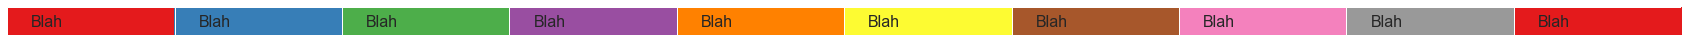

In [5]:
from matplotlib import pyplot as plt
import matplotlib as mpl
def keyplot(pal, names):
    
    """Plot the values in a color palette as a horizontal array.
    Parameters
    ----------
    pal : sequence of matplotlib colors
        colors, i.e. as returned by seaborn.color_palette()
    size :
        scaling factor for size of plot
    """
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * 3, .5))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    for i,name in enumerate(names):
        ax.annotate(name,(-.35+i,0.2),fontsize=16)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
keyplot(sns.color_palette('Set1',10),names=['Blah']*10)

In [6]:
gn_data = pd.read_table('/Users/jaredlorince/Dropbox (Personal)/Research/PROJECTS/MusicStuff/gracenote_song_data')
#artist_data = gn_data.groupby('gn_artist').apply(lambda df: df.iloc[0])
#genre_data = artist_data[['genre1','genre2','genre3']].reindex(pd.Series(vocab_idx.values())).reset_index()

In [7]:
artist_genres = gn_data.groupby('gn_artist').first()

In [8]:
%%time
something =artist_genres.shape
for i in xrange(10000000):
    pass
for i in xrange(10000000):
    pass


CPU times: user 1.78 s, sys: 18 ms, total: 1.8 s
Wall time: 2.02 s


In [9]:
#fi = 'artist_output_normed-w2v-200-p50'
#fi = 'artist_output_normed-w2v-200-15-p50'
#fi = 'artist_output_normed-w2v-400-15-p50'
#fi = 'artist_output_normed-w2v-400-50-p50'
fi = 'fm_lv'
delim = ' '
coords = pd.read_table('../data/'+fi,header=None,names=['x','y'],delimiter=' ')
coords.index = [line.strip() for line in open('../data/artist-idx-w2v-200-5')]#[:100000]


In [10]:
data = artist_genres.join(coords,how='inner')

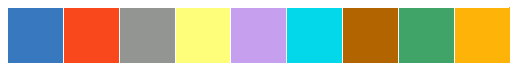

In [14]:
colors = ["windows blue", "reddish orange", "grey", "light yellow","lavender", "aqua blue","umber","greenish","amber"]
sns.palplot(sns.xkcd_palette(colors))
colors = sns.xkcd_palette(colors)

color_dict = dict(zip(['urban','pop', 'classical', 'traditional', 'rock',
       'alternative & punk',  'soundtrack','jazz', 'electronica'],['#%02x%02x%02x' % (a, b, c) for a,b,c in np.round(255*np.array(colors)).astype(int)]))
plt_data = data[data['genre1']!='other'].dropna(subset=['genre1']).reset_index(drop=True)


for x in ('genre1','genre2','genre3'):
    plt_data[x] = plt_data[x].astype('category')

plot_width  = int(900)
plot_height = int(900)
background = "black"

import datashader as ds
import datashader.transfer_functions as tf
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, Hot, viridis, inferno
from IPython.core.display import HTML, display


export = partial(export_image, background = background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))

display(HTML("<style>.container { width:100% !important; }</style>"))

def create_image(x_range=(-30,30), y_range=(-30,30), w=plot_width, h=plot_height):       
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(plt_data, 'x', 'y', ds.count_cat('genre1'))
    img = tf.shade(agg, color_key=color_dict, how='eq_hist')
    return tf.dynspread(img,threshold=0.5, max_px=8)
    #return img

In [12]:
data[['x','y']].describe()

x              y
count  241711.000000  241711.000000
mean       -2.524460       0.705829
std        10.876385      11.508665
min       -43.499268     -27.872719
25%       -10.221760      -7.457445
50%        -3.071443      -0.631190
75%         4.634611      10.260081
max        28.616899      31.470461

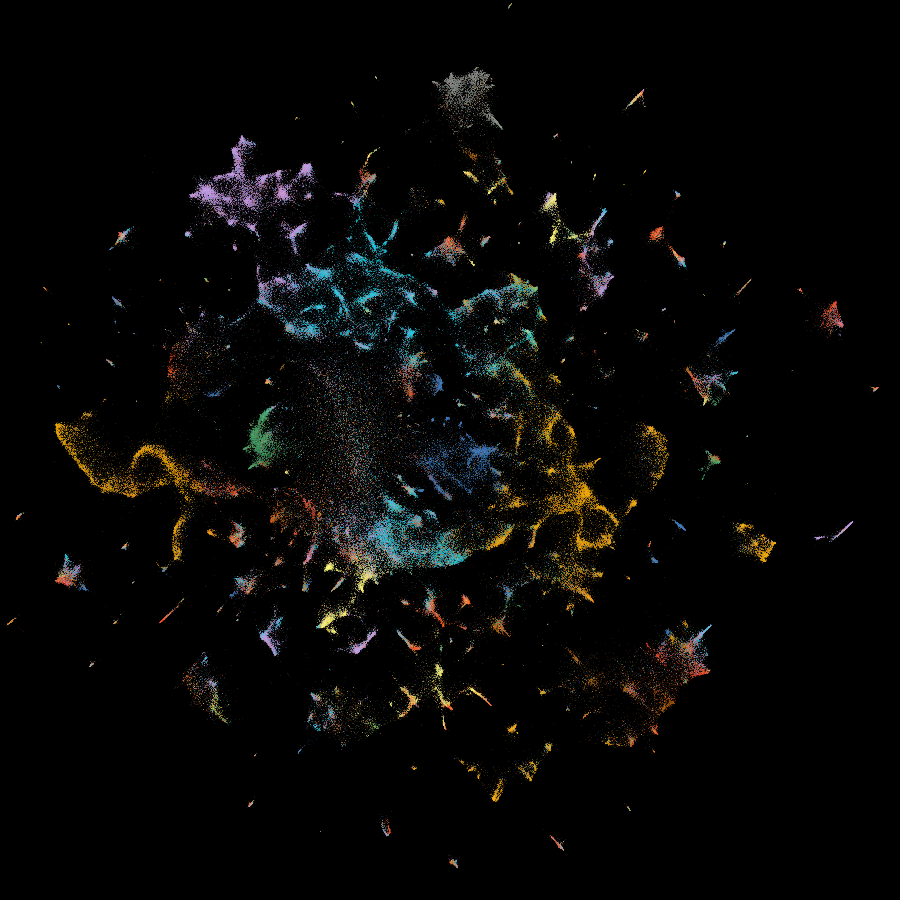

In [15]:
export(create_image(),'test')


In [32]:
import bokeh.plotting as bp
from bokeh.models.tiles import WMTSTileSource
from datashader.bokeh_ext import InteractiveImage


bp.output_notebook()
x_range = (-44,44)
y_range = (-44,44)

def base_plot(tools='pan,wheel_zoom,reset,box_zoom,save,crosshair',webgl=False):
    p = bp.figure(tools=tools,
        plot_width=int(900), plot_height=int(900),
        x_range=x_range, y_range=y_range, outline_line_color=None,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0, webgl=webgl)
    
    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.background_fill_color = "black"
    
    return p

Loading BokehJS ...

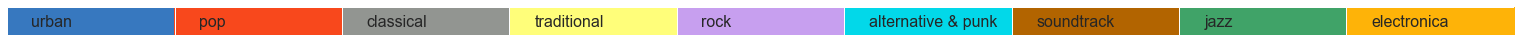

In [33]:
def image_callback(x_range=(-13,13), y_range=(-13,13), w=plot_width, h=plot_height,g1=None):
    df = plt_data.copy()
    cat = 'genre1'
    if g1 is not None:
        df = df[df['genre1']==g1]
        cat = 'genre2'
        df[cat] = df[cat].astype(str)
        topN = df[cat].value_counts()[:9].index.values
        df = df[plt_data[cat].isin(topN)]
        color_dict = dict(zip(topN,['#%02x%02x%02x' % (a, b, c) for a,b,c in np.round(255*np.array(colors)).astype(int)]))
        keyplot(colors,topN)
    else:
        genres = ['urban','pop', 'classical', 'traditional', 'rock','alternative & punk',  'soundtrack','jazz', 'electronica']
        c = ['#%02x%02x%02x' % (a, b, c) for a,b,c in np.round(255*np.array(colors)).astype(int)]
        color_dict = dict(zip(genres,c))
        keyplot(colors,genres)
    df[cat] = df[cat].astype('category')

       
    #df[cat] = df[cat].astype('category')
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    #print len(colors),len(df[cat].unique())
    agg = cvs.points(df, 'x', 'y', ds.count_cat(cat))
    img = tf.shade(agg, color_key=color_dict, how='eq_hist')
    
    return tf.dynspread(img,threshold=0.75, max_px=4)
    #return img

p = base_plot()



InteractiveImage(p, image_callback)#,g1='electronica')


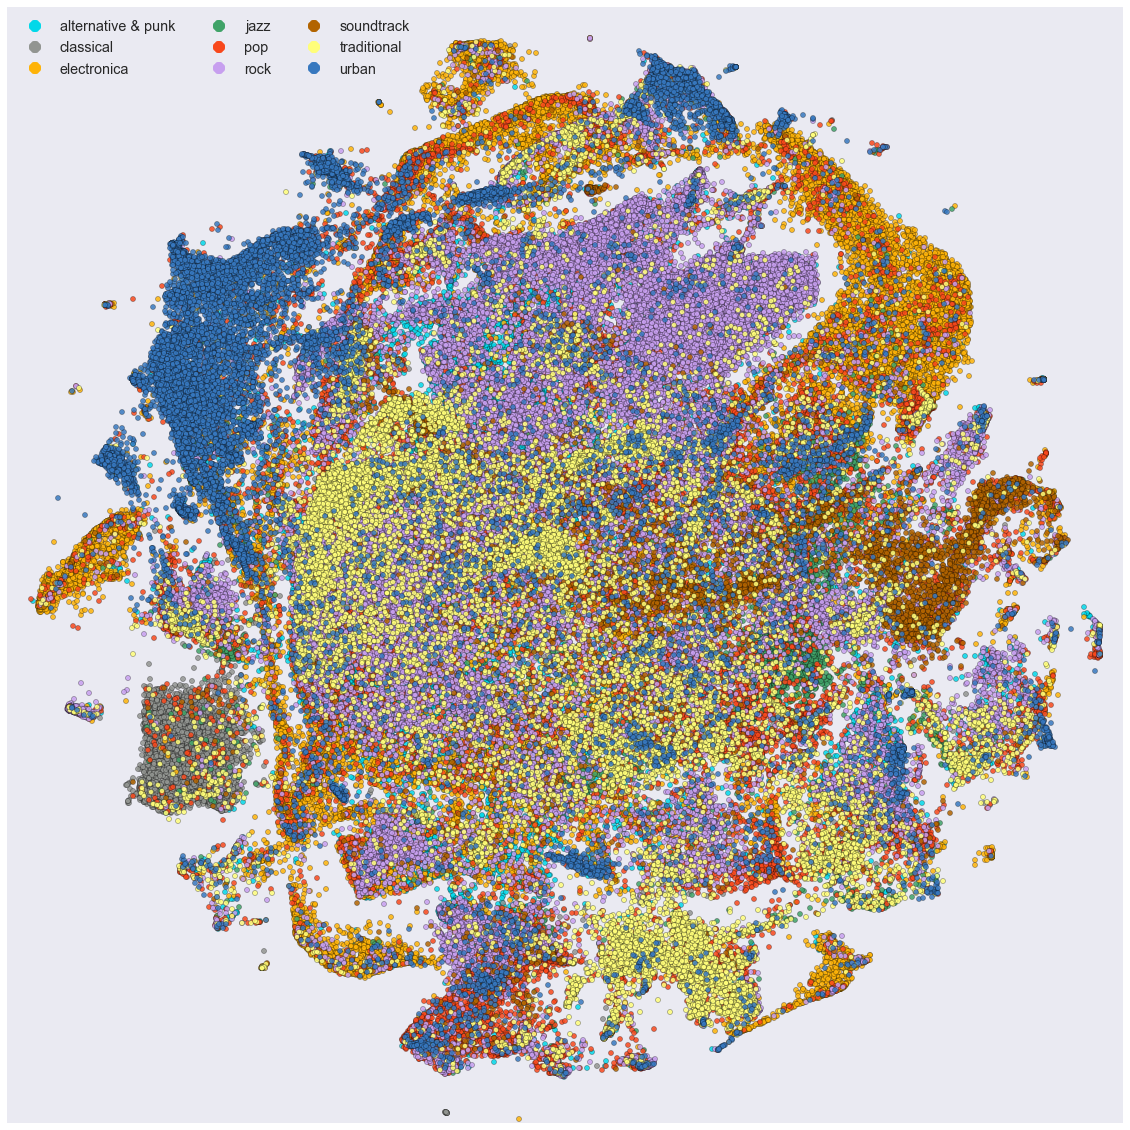

In [154]:
fig,ax = plt.subplots(1,1,figsize=(20,20))
for g in sorted(color_dict.keys()):
    indices = plt_data[plt_data['genre1']==g].index.values
    ax.scatter(plt_data['x'][indices],plt_data['y'][indices],c=color_dict[g],s=25,alpha=.85,edgecolors=None)
    legend_line_1 = ax.plot(np.NaN, np.NaN, marker = '.', ls='',ms=25, label=g, color=color_dict[g],lw=1)
    
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_xlim(-13,13)
ax.set_ylim(-13,13)

#ax.axvline(-8.21141179,c='k')
#ax.axhline(3.52799834,c='k')
    
ax.legend(loc='upper left',ncol=3,fontsize='x-large')
ax.grid()

In [17]:
x=pd.read_table('/Users/jaredlorince/Desktop/test_output.txt',delimiter=' ',skiprows=1,names= ['x','y'])

/Users/jaredlorince/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


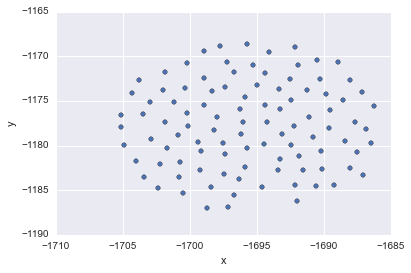

In [18]:
x.plot(kind='scatter',x='x',y='y')